In [ ]:
!pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma bs4 langchain-google-genai langchain_core google-cloud-aiplatform

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(model="gemini-pro")

In [ ]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"))

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. It can be done by using a language learning model (LLM) with simple prompting, by using task-specific instructions, or with human inputs. Task decomposition helps the model to utilize more test-time computation and to transform big tasks into multiple manageable tasks.'

In [ ]:
vectorstore.delete_collection()

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

model = ChatGoogleGenerativeAI(model="gemini-pro", convert_system_message_to_human=True)
model(
    [
        SystemMessage(content="Answer only yes or no."),
        HumanMessage(content="Is apple a fruit?"),
    ]
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
/root/.local/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:345: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


AIMessage(content='Yes', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ab779925-33f2-453f-82f3-502524c055ad-0', usage_metadata={'input_tokens': 12, 'output_tokens': 1, 'total_tokens': 13})

In [ ]:
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"))
retriever = vectorstore.as_retriever()


# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

"Task decomposition is the process of breaking down a complex task into smaller, more manageable steps. This allows large language models (LLMs) to tackle difficult problems by addressing them in a step-by-step manner. This approach enhances the model's performance and provides insights into its reasoning process. \n"

#Adding chat history

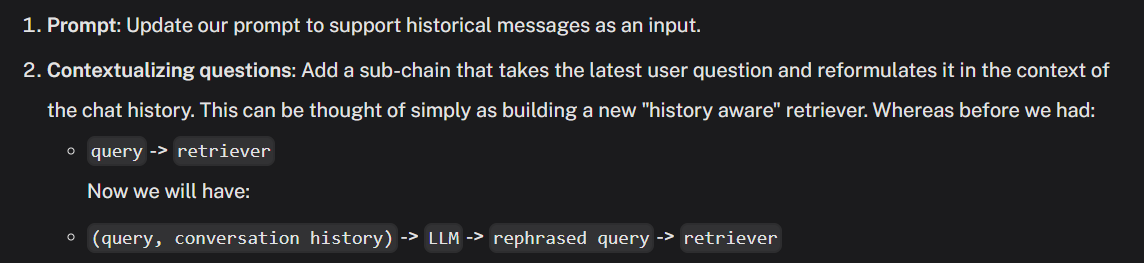

In [13]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [14]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [16]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are common ways of doing it?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Task decomposition can be achieved in a few common ways.  You can use simple prompts like "Steps for XYZ" or "Subgoals for achieving XYZ", provide task-specific instructions like "Write a story outline," or rely on human input to break down the task. 



In [17]:
chat_history.extend(
    [
        HumanMessage(content=second_question),
        AIMessage(content=ai_msg_2["answer"]),
    ]
)

In [18]:
third_question = "What are its advantages?"
ai_msg_3 = rag_chain.invoke({"input": third_question, "chat_history": chat_history})

print(ai_msg_3["answer"])

Task decomposition makes complex tasks easier for large language models to understand and execute. By breaking down problems into smaller steps, it allows models to approach tasks more systematically and enhances their performance. This approach also offers insights into the model's reasoning process, making it easier to interpret. 



#Stateful management of chat history

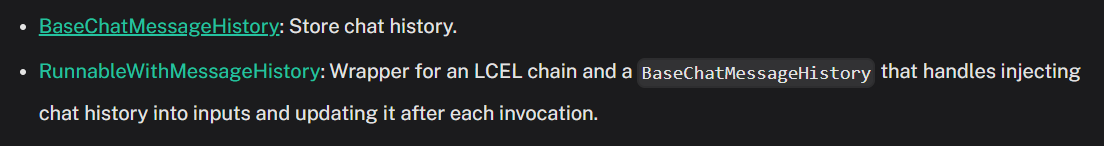

In [19]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [20]:
conversational_rag_chain.invoke(
    {"input": "What is Task Decomposition?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)["answer"]

'Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. This approach enhances model performance by allowing the model to focus on one step at a time. This decomposition can be achieved using methods like Chain of Thought prompting or Tree of Thoughts, which explore multiple reasoning possibilities. \n'

In [21]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What is Task Decomposition?'), AIMessage(content='Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. This approach enhances model performance by allowing the model to focus on one step at a time. This decomposition can be achieved using methods like Chain of Thought prompting or Tree of Thoughts, which explore multiple reasoning possibilities. \n')])}

In [22]:
conversational_rag_chain.invoke(
    {"input": "What are common ways of doing it?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'Task decomposition can be done in a few ways. You can use simple prompts with an LLM, like "Steps for XYZ" or "What are the subgoals for achieving XYZ?". Alternatively, you can use task-specific instructions like "Write a story outline" for novel writing, or you can provide human input for decomposition. \n'

In [23]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What is Task Decomposition?'), AIMessage(content='Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. This approach enhances model performance by allowing the model to focus on one step at a time. This decomposition can be achieved using methods like Chain of Thought prompting or Tree of Thoughts, which explore multiple reasoning possibilities. \n'), HumanMessage(content='What are common ways of doing it?'), AIMessage(content='Task decomposition can be done in a few ways. You can use simple prompts with an LLM, like "Steps for XYZ" or "What are the subgoals for achieving XYZ?". Alternatively, you can use task-specific instructions like "Write a story outline" for novel writing, or you can provide human input for decomposition. \n')])}

In [24]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. This approach enhances model performance by allowing the model to focus on one step at a time. This decomposition can be achieved using methods like Chain of Thought prompting or Tree of Thoughts, which explore multiple reasoning possibilities. 


User: What are common ways of doing it?

AI: Task decomposition can be done in a few ways. You can use simple prompts with an LLM, like "Steps for XYZ" or "What are the subgoals for achieving XYZ?". Alternatively, you can use task-specific instructions like "Write a story outline" for novel writing, or you can provide human input for decomposition. 




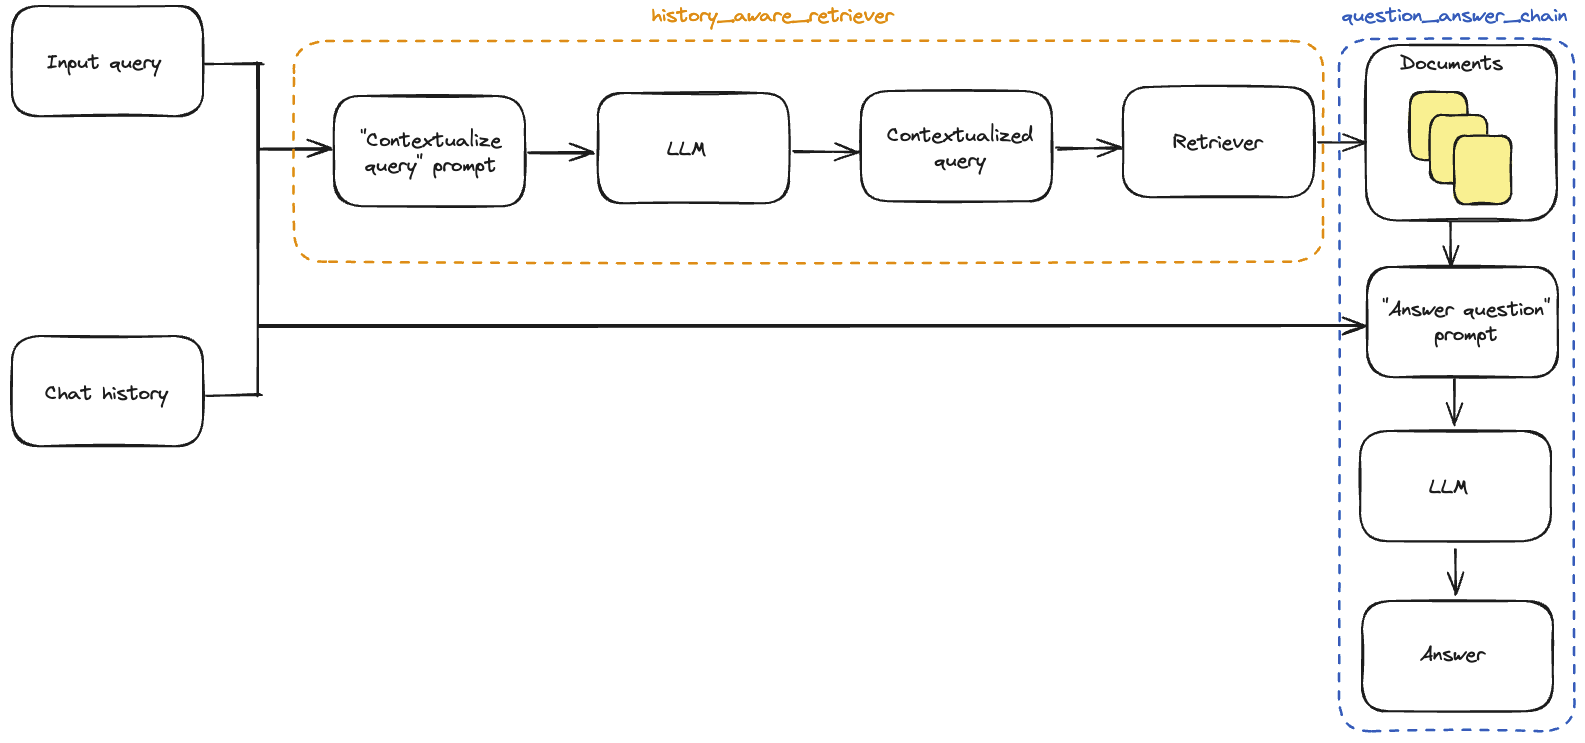

#Agents

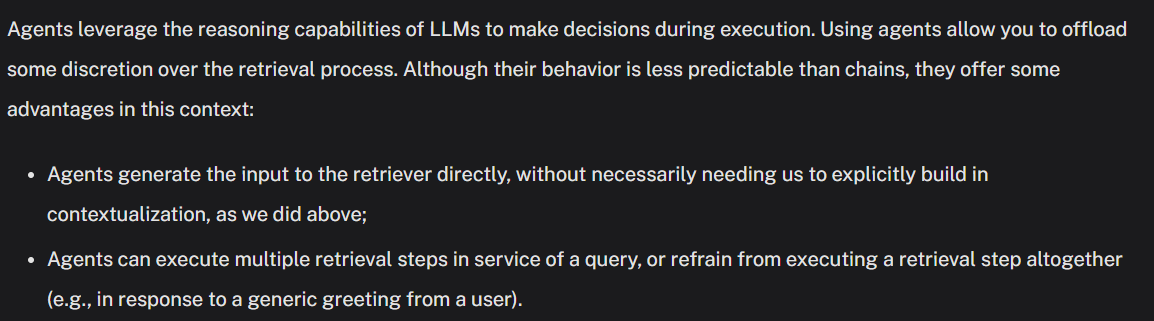

In [25]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]

In [26]:
tool.invoke("task decomposition")

'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by st

###Agent constructor

In [28]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.4 MB/s eta 0:00:00


In [29]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

In [30]:
query = "What is Task Decomposition?"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'blog_post_retriever', 'arguments': '{"query": "Task Decomposition"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-7f050801-ab9c-4a3f-ae69-6c117b3a5813-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'Task Decomposition'}, 'id': 'a2c1adae-c300-4d49-bcaa-f8ed2b404602'}], usage_metadata={'input_tokens': 58, 'output_tokens': 19, 'total_tokens': 77})]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 1. Overview of a LLM

LangGraph comes with built in persistence, so we don't need to use ChatMessageHistory! Rather, we can pass in a checkpointer to our LangGraph agent directly



In [31]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

agent_executor = create_react_agent(llm, tools, checkpointer=memory)

In [32]:
config = {"configurable": {"thread_id": "abc123"}}

for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Hi! I'm Wilfredo")]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='Hi Wilfredo! 👋 \n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-6b45d4cf-b2c1-402c-ba21-8558a0a5737b-0', usage_metadata={'input_tokens': 60, 'output_tokens': 5, 'total_tokens': 65})]}}
----


In [33]:
query = "What is Task Decomposition?"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'blog_post_retriever', 'arguments': '{"query": "What is Task Decomposition?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-03ef5c04-25ec-4333-9a60-57a6408611b3-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'What is Task Decomposition?'}, 'id': 'e6df8498-bb70-439a-a0a7-49af8116ae28'}], usage_metadata={'input_tokens': 74, 'output_tokens': 22, 'total_tokens': 96})]}}
----
{'tools': {'messages': [ToolMessage(content='Fig. 1.

In [34]:
query = "What according to the blog post are common ways of doing it? redo the search"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'blog_post_retriever', 'arguments': '{"query": "What are common ways of doing Task Decomposition?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3c3523b0-8bc9-49ca-a01c-7ea4f36fcf8c-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'What are common ways of doing Task Decomposition?'}, 'id': 'b125d8f0-db7b-4625-a655-ca836790ac4c'}], usage_metadata={'input_tokens': 1012, 'output_tokens': 26, 'total_tokens': 1038})]}}
----
{'to

In [35]:
query = "What are its advantages? redo the search"

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'blog_post_retriever', 'arguments': '{"query": "What are the advantages of Task Decomposition?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-66e51725-99ee-4322-8ce6-81a8cc488803-0', tool_calls=[{'name': 'blog_post_retriever', 'args': {'query': 'What are the advantages of Task Decomposition?'}, 'id': '18ad482a-0115-4cdc-8945-b4981b2c4796'}], usage_metadata={'input_tokens': 1880, 'output_tokens': 25, 'total_tokens': 1905})]}}
----
{'tools': 